In [98]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns    
import scipy                                     


In [99]:
gse = GEOparse.get_GEO("GSE4271", destdir="data/",silent=True)

In [100]:
expression_df = gse.pivot_samples('VALUE') # Some values in the thousands, apply log2 transformation
expression_df = np.log2(expression_df + 1.0)


meta = []
for gsm_name, gsm in gse.gsms.items():
    characteristics = gsm.metadata.get('characteristics_ch1', [])
    char_dict = {}
    for entry in characteristics:
        if ":" in entry:
            key, value = entry.split(":", 1)
            char_dict[key.strip()] = value.strip()   
    char_dict["sample"] = gsm_name
    char_dict["title"] = gsm.metadata.get("title", [""])[0]
    char_dict["source_name"] = gsm.metadata.get("source_name_ch1", [""])[0]
    meta.append(char_dict)
    
    
meta_df = pd.DataFrame(meta).set_index('sample')

# Getting indexes of primary and recurrent samples from metadata

primary_samples = meta_df[meta_df['specimen type'] == 'primary'].index
recurrent_samples = meta_df[meta_df['specimen type'] == 'recurrent'].index

#Create expression dataframes for primary and recurrent samples
primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]



print("Primary samples shape:", primary_expression.head())
print("Recurrent samples shape:", recurrent_expression.head())

Primary samples shape: name        GSM96950   GSM96951   GSM96952   GSM96953   GSM96954   GSM96955  \
ID_REF                                                                        
1007_s_at  12.349972  12.055147  12.531479  12.549761  12.251009  13.014491   
1053_at     8.407268   8.807355   8.569476   8.843921   9.664447   8.121534   
117_at      7.572890  10.089980   8.364135   6.563768   6.619120   6.970394   
121_at      9.795553   9.830990   9.854868  10.076682   9.754052  10.305036   
1255_g_at   5.937815   4.995485   5.381975   5.495056   5.429616   5.314697   

name        GSM96958   GSM96959   GSM96961   GSM96962  ...  GSM97137  \
ID_REF                                                 ...             
1007_s_at  12.711947  12.251601  12.256268  11.089649  ...       NaN   
1053_at     8.630449   9.198445   8.539934   9.482203  ...       NaN   
117_at      7.252665   7.500643   7.835419   7.084277  ...       NaN   
121_at      9.506208   9.953032   9.935754  10.058533  ...     

In [101]:
gpl1 = gse.gpls['GPL96']
gpl2 = gse.gpls['GPL97']
gene_id1 = gpl1.table[['ID', 'Gene Symbol']]
gene_id2 = gpl2.table[['ID', 'Gene Symbol']]

# Combine gene annotation from both platforms
gene_id = pd.concat([gene_id1, gene_id2], axis=0)
gene_id = gene_id.rename(columns={"ID":"ID_REF"}).set_index("ID_REF")

print(gene_id.head())


                Gene Symbol
ID_REF                     
1007_s_at  DDR1 /// MIR4640
1053_at                RFC2
117_at                HSPA6
121_at                 PAX8
1255_g_at            GUCA1A


In [ ]:
# Map probe IDs to gene symbols
primary_expression = primary_expression.merge(gene_id, left_index=True, right_index=True)





MergeError: Passing 'suffixes' which cause duplicate columns {'Gene Symbol_x'} is not allowed.

In [104]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

# 1) Align genes and aggregate duplicate probes by mean
common_genes = primary_expression.index.intersection(recurrent_expression.index)
prim = primary_expression.loc[common_genes].copy()
rec = recurrent_expression.loc[common_genes].copy()

# If probes map to the same gene symbol, aggregate by mean
if prim.index.duplicated().any():
    prim = prim.groupby(level=0).mean()
if rec.index.duplicated().any():
    rec = rec.groupby(level=0).mean()

# Ensure same ordered index
genes = prim.index.intersection(rec.index)
prim = prim.loc[genes].astype(float)
rec = rec.loc[genes].astype(float)

# 2) Remove genes with any NaN across samples (or impute if you prefer)
na_genes = prim.isna().any(axis=1) | rec.isna().any(axis=1)
print("genes total:", len(genes), "genes with NaN (will be dropped):", na_genes.sum())
prim = prim.loc[~na_genes]
rec = rec.loc[~na_genes]

# 3) Check group sizes
n_prim = prim.shape[1]
n_rec = rec.shape[1]
print("primary samples:", n_prim, "recurrent samples:", n_rec)
if n_prim < 2 or n_rec < 2:
    print("WARNING: <2 samples in a group -> t-test unreliable")

# 4) per-gene t-test (axis=1: each row is a gene)
tt = stats.ttest_ind(rec.values, prim.values, axis=1, equal_var=False, nan_policy='omit')
p_values = tt.pvalue
# replace NaN p-values (e.g., constant values or insufficient data) with 1.0
p_values = np.where(np.isfinite(p_values), p_values, 1.0)

# 5) fold change
fold_changes = rec.mean(axis=1) - prim.mean(axis=1)

# 6) Build dataframe and adjust p-values
volcano_df = pd.DataFrame({
    'log2FC': fold_changes,
    'p-value': p_values
}, index=prim.index)

volcano_df['adj p-value'] = multipletests(volcano_df['p-value'], method='fdr_bh')[1]

print("tested genes:", volcano_df.shape[0])
print(volcano_df.head())

TypeError: agg function failed [how->mean,dtype->object]

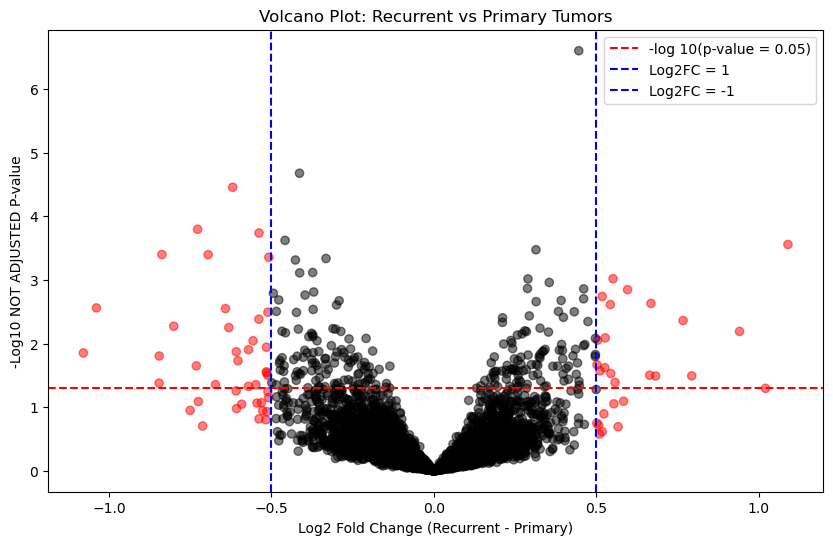

In [ ]:
# Plot volcano plot

colors = np.where(abs(volcano_df["log2FC"]) >= 0.5, "red", "black")

plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2FC'], volcano_df['-log10 p-value'], alpha=0.5, c=colors)
plt.title('Volcano Plot: Recurrent vs Primary Tumors')

plt.xlabel('Log2 Fold Change (Recurrent - Primary)')
plt.ylabel('-Log10 NOT ADJUSTED P-value')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='-log 10(p-value = 0.05)')

plt.axvline(x=0.5, color='blue', linestyle='--', label='Log2FC = 1')
plt.axvline(x=-0.5, color='blue', linestyle='--', label='Log2FC = -1')
plt.legend()
